# Import Libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import pandas as pd
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

2024-05-17 05:10:19.552822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 05:10:19.552919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 05:10:19.688242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import load_img, img_to_array
from tqdm import tqdm
import re
import pickle
from keras.layers import LeakyReLU,BatchNormalization

# Question Encoding

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence is when you get the most of the language getting simple proof by contradiction where", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/facebook-dpr-question_encoder-single-nq-base')
embeddings = model.encode(questions)
print(embeddings)


In [ ]:
# Read dictionary pkl file
with open('/kaggle/input/question-embeddings/question_embeddings.pkl', 'rb') as fp:
    embeddings = pickle.load(fp)
    print('successful')

successful


In [ ]:
embeddings.shape

(658111, 768)

# Image Feature Extraction

In [ ]:
from PIL import Image
import timm
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = timm.create_model(
    'vit_base_patch14_reg4_dinov2.lvd142m',
    pretrained=True,
    num_classes=0  # remove classifier nn.Linear
).eval().to(device)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
image_dir =  '/kaggle/input/visual-question-answering/train2014/train2014'

train_features = []
for filename in tqdm(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, filename)
    img = Image.open(image_path).convert("RGB")  # Convert image to RGB if needed

    # Apply transforms and move data to GPU
    inputs = transforms(img).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model.forward_features(inputs)
        output = model.forward_head(output, pre_logits=True)
    train_features.append(output.cpu().numpy())# Move data back to CPU and convert to numpy array

In [ ]:
type(train_features)

In [ ]:
# add ids to features
img_ids = np.array([int(re.search("[0-9][0-9][0-9][0-9][0-9]+", gen).group()) for gen in generator.filenames])
image_features = {}
for i in range(len(img_ids)):
    image_features[img_ids[i]]= train_features[i]

In [ ]:
# Concatenate and reshape the extracted features into a numpy array
train_features = np.concatenate(train_features)
train_features = train_features.reshape((len(os.listdir(image_dir)), -1))

# Save the extracted features to a numpy file
np.save(output_file, train_features)

In [ ]:
# Save dictionary to train_image_features.pkl file
with open('val_image_features.pkl', 'wb') as fp:
    pickle.dump(train_features, fp)
    print('Dictionary saved successfully to file.')

In [ ]:
output.shape

# Read all files

In [ ]:
train_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
train_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
val_file_questions = '/kaggle/input/visual-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
val_file_annotations = '/kaggle/input/visual-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'

with open(train_file_questions, 'r') as f:
    train_questions = json.load(f)['questions']
    f.close()

with open(train_file_annotations, 'r') as f:
    train_annotations = json.load(f)['annotations']
    f.close()

with open(val_file_questions, 'r') as f:
    val_questions = json.load(f)['questions']
    f.close()

with open(val_file_annotations, 'r') as f:
    val_annotations = json.load(f)['annotations']
    f.close()


#### read all train and validate image features with IDs from the pkl files

# Read dictionary pkl file
with open('/kaggle/input/image-features/train_image_features.pkl', 'rb') as fp:
    train_imgs_features = pickle.load(fp)
    print('successful')
#Read dictionary pkl file
with open('/kaggle/input/image-features/val_image_features (1).pkl', 'rb') as fp:
    val_imgs_features = pickle.load(fp)
    print('successful')

#### append validate to train features
print("Length of train_imgs_features:", len(train_imgs_features))
print("Length of val_imgs_features:", len(val_imgs_features))

#train_imgs_features = np.concatenate((train_imgs_features, val_imgs_features), axis=0)
train_imgs_features.update(val_imgs_features)

print(len(train_imgs_features))

#### append validate questions and answers to train questions and answers

# Combine the training and validation questions and annotations
train_questions += val_questions
train_annotations += val_annotations

successful
successful
Length of train_imgs_features: 82783
Length of val_imgs_features: 40504
123287


# Extracting questions,answers,ids

In [ ]:
# Extract the questions and answers
questions = []
answers = []
features_id = []

for i in range(len(train_questions)):
    questions.append(train_questions[i]['question'])
    answers.append(train_annotations[i]['multiple_choice_answer'])
    features_id.append(train_questions[i]["image_id"])
print("Length of features_id:", len(features_id))
print("Maximum index in features_id:", max(features_id))

Length of features_id: 658111
Maximum index in features_id: 581929


# Question Encoding

In [ ]:
# Tokenize the questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
with open('tokenizer_Full.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
    print('tokenizer save successfully to file')
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(questions)

max_question_length = max([len(question) for question in questions])
padded_sequences = pad_sequences(sequences, maxlen=max_question_length)

In [ ]:
type(padded_sequences)

# Answers to one-hot-encoding

In [ ]:
# Convert the answers to one-hot vectors
answers_tokenizer = Tokenizer()
answers_tokenizer.fit_on_texts(answers)
answer_word_index = answers_tokenizer.word_index
num_classes = len(answer_word_index)
answer_sequences = answers_tokenizer.texts_to_sequences(answers)

# Pad the answer sequences to ensure they all have the same length
max_answer_length = max(len(seq) for seq in answer_sequences)
padded_answers = pad_sequences(answer_sequences, maxlen=max_answer_length)

# Get the unique answers in the dataset and create a dictionary to map them to integer labels
unique_answers = list(set(answers))
label_map = {answer: i for i, answer in enumerate(unique_answers)}
with open('label_map_Full.pkl', 'wb') as fp:
    pickle.dump(label_map, fp)
    print('label_map save successfully to file')

# Convert the answers to integer labels and then to one-hot vectors
labels = [label_map[answer] for answer in answers]
one_hot_answers = to_categorical(labels, num_classes=len(unique_answers))

#### shape of the dataset

print(len(features_id))
print(embeddings.shape)
print(one_hot_answers.shape)

label_map save successfully to file
658111
(658111, 768)
(658111, 29332)


# Train,Test,Validation split

In [ ]:
### split train into 80% train and 20% test
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(features_id), size=int(len(features_id)*0.2))
split_indices = sorted(split_indices,reverse=True)

test_padded_sequences = []
padded_sequences = list(embeddings)
for i in split_indices:
    test_padded_sequences.append(padded_sequences.pop(i))

test_one_hot_answers = []
one_hot_answers = list(one_hot_answers)
for i in split_indices:
    test_one_hot_answers.append(one_hot_answers.pop(i))

test_features_id = []
for i in split_indices:
    test_features_id.append(features_id.pop(i))

### split 30% test into 20% test and 10% validate
#### (inplace to prevent memory overflow)

split_indices = np.random.randint(low=0, high=len(test_features_id), size=int(len(test_features_id)*0.5))
split_indices = sorted(split_indices,reverse=True)

val_padded_sequences = []
for i in split_indices:
    val_padded_sequences.append(test_padded_sequences.pop(i))

val_one_hot_answers = []
for i in split_indices:
    val_one_hot_answers.append(test_one_hot_answers.pop(i))

val_features_id = []
for i in split_indices:
    val_features_id.append(test_features_id.pop(i))
print("Length of val_features_id:", len(val_features_id))
print("Maximum index in val_features_id:", max(val_features_id))


Length of val_features_id: 65811
Maximum index in val_features_id: 581929


In [ ]:
# Load the saved model
model = tf.keras.models.load_model("/kaggle/input/dino_dpr/tensorflow2/version-2/1/Dino_DPR_2.h5")
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

In [ ]:
model.summary()

# LoRA class

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class LoRALayer(Layer):
    def __init__(self, units, rank=1, alpha=1, **kwargs):
        super(LoRALayer, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.alpha = alpha
        self.scale = self.alpha / self.rank

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)

        self.A = self.add_weight(name='A',
                                 shape=(input_shape[-1], self.rank),
                                 initializer='random_normal',
                                 trainable=True)

        self.B = self.add_weight(name='B',
                                 shape=(self.rank, self.units),
                                 initializer='random_normal',
                                 trainable=True)

        self.b = self.add_weight(name='b',
                                 shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        original_out = tf.matmul(inputs, self.W) + self.b
        lora_out = self.scale * tf.matmul(tf.matmul(inputs, self.A), self.B)
        return original_out + lora_out

    def get_config(self):
        config = super(LoRALayer, self).get_config()
        config.update({
            'units': self.units,
            'rank': self.rank,
            'alpha': self.alpha,
        })
        return config

# Ensure the custom layer is recognized when loading the model
tf.keras.utils.get_custom_objects().update({'LoRALayer': LoRALayer})


In [ ]:
def apply_lora(model):
    for layer in model.layers:
        if isinstance(layer, LoRALayer):
            # Ensure the LoRALayer's weights are trainable
            for weight in layer.trainable_weights:
                weight._trainable = True


# Architecture


In [ ]:
# Define the input layers
question_input = Input(shape=(768,), name='question_input')
image_input = Input(shape=(768,), name='image_input')

# Define the dense layer for the image features
image_dense = LoRALayer(units=256, alpha=1, rank=1, name='image_dense')(image_input)
image_dense = Dropout(0.2, name='image_dropout')(image_dense)

# Concatenate the output from the LSTM and dense layers
concatenated = concatenate([question_input, image_input], name='concatenated')

dense_cnc = LoRALayer(units=512, alpha=1, rank=1, name='dense_cnc')(concatenated)
dense_cnc2 = Dense(units=256, activation='relu', name='dense_cnc2')(dense_cnc)
dense_cnc3 = LoRALayer(units=512, alpha=1, rank=1, name='dense_cnc3')(dense_cnc2)
dense_cnc4 = Dense(units=256, activation='relu', name='dense_cnc4')(dense_cnc3)

# Define the output layer for the classification
output = Dense(units=len(unique_answers), activation='softmax', name='output')(dense_cnc4)

In [ ]:
# Create the model
model = Model(inputs=[question_input, image_input], outputs=output)

# Apply LoRA to the model
apply_lora(model)

# Compile the model with SGD optimizer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 1536)      │          0 │ question_input[0… │
│ (Concatenate)       │                   │            │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc           │ (None, 512)       │    788,992 │ concatenated[0][… │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc2 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc3          │ (None, 512)       │    132,352 │ dense_cnc2[0][0]  │
│ (LoRALayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_cnc4 (Dense)  │ (None, 256)       │    131,328 │ dense_cnc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 29332)     │  7,538,324 │ dense_cnc4[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,722,324 (33.27 MB)

 Trainable params: 8,722,324 (33.27 MB)

 Non-trainable params: 0 (0.00 B)

# Data Generator for training

In [ ]:
def data_generator(image_features, padded_questions, labels, batch_size):
        num_samples = len(labels)
        steps_per_epoch = num_samples // batch_size
        while True:
            for i in range(steps_per_epoch):
                batch_image_features = []
                for j in range(i*batch_size, (i+1)*batch_size):
                     # Check if the index is within bounds
                    if j < len(image_features):
                        batch_image_features.append(train_imgs_features[image_features[j]])
                batch_padded_questions = padded_questions[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]
                yield (
                  (
                    tf.convert_to_tensor(batch_padded_questions, dtype=tf.float32),
                    tf.convert_to_tensor(batch_image_features, dtype=tf.float32)
                  ),
                tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

Using only (1/4)th of dataset as specified in project

In [ ]:
size = len(features_id)
split = size//4
fd = features_id[:split]
ps = padded_sequences[:split]
oha = one_hot_answers[:split]
size = len(val_features_id)
val_split = (size//4)
vfd = val_features_id[:val_split]
vps = val_padded_sequences[:val_split]
voha = val_one_hot_answers[:val_split]
len(voha)

16452

In [ ]:
# Define a function to generate data for evaluation
def eval_data_generator(image_features, padded_questions, batch_size):
    num_samples = len(image_features)
    steps_per_epoch = num_samples // batch_size
    while True:
        for i in range(steps_per_epoch):
            batch_image_features = []
            for j in range(i * batch_size, (i + 1) * batch_size):
                # Check if the index is within bounds
                if j < len(image_features):
                    batch_image_features.append(train_imgs_features[image_features[j]])
            batch_padded_questions = padded_questions[i * batch_size:(i + 1) * batch_size]
            yield (
                (
                    tf.convert_to_tensor(batch_padded_questions, dtype=tf.float32),
                    tf.convert_to_tensor(batch_image_features, dtype=tf.float32)
                )
            )

# Training Loop
These epochs are (11-15)

In [ ]:
batch_size = 64
steps_per_epoch = len(oha) // batch_size

# Khởi tạo ModelCheckpoint
# checkpoint = ModelCheckpoint('xception_lstm_all_Full_80.h5', monitor='val_accuracy', save_best_only=True)
checkpoint = ModelCheckpoint('dino_dpr_lora.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(data_generator(fd, ps ,oha,batch_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=5,
                        validation_data = data_generator(vfd,vps,voha,batch_size),
                        validation_steps = int(len(vfd)/batch_size),
                        callbacks=[checkpoint])

Epoch 1/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 671s 326ms/step - accuracy: 0.3054 - loss: 3.2410 - val_accuracy: 0.2817 - val_loss: 3.5311
Epoch 2/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 675s 328ms/step - accuracy: 0.3135 - loss: 3.1597 - val_accuracy: 0.2846 - val_loss: 3.5057
Epoch 3/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 663s 323ms/step - accuracy: 0.3207 - loss: 3.0824 - val_accuracy: 0.2879 - val_loss: 3.4896
Epoch 4/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 669s 325ms/step - accuracy: 0.3292 - loss: 3.0070 - val_accuracy: 0.2893 - val_loss: 3.4812
Epoch 5/5
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 672s 327ms/step - accuracy: 0.3375 - loss: 2.9332 - val_accuracy: 0.2907 - val_loss: 3.4781


In [ ]:
# Extract the history dictionary
history_dict = history.history

# Convert the history dictionary to a DataFrame
history_df = pd.DataFrame(history_dict)

history_df.to_csv('training_history1.csv', index=False)

# Display the DataFrame
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.307431,3.225188,0.281676,3.531116
1,0.315365,3.144451,0.284594,3.505692
2,0.323444,3.067369,0.287938,3.489613
3,0.332024,2.992371,0.289275,3.481243
4,0.340627,2.918941,0.290674,3.478132


# Gathering Info per Epoch
(With LoRA Fine-Tuning)

In [ ]:
import pandas as pd

# Initial data
initial_epochs = list(range(6, 11))
initial_accuracy = [0.2673805356025696, 0.2750866413116455, 0.2832867205142975, 0.2916007936000824, 0.29954248666763306]
initial_val_accuracy = [0.2602140009403229, 0.26453062891960144, 0.2681176960468292, 0.27383267879486084, 0.27638620138168335]

# New data
new_epochs = list(range(11, 16))
new_accuracy = [0.307431, 0.315365, 0.323444, 0.332024, 0.340627]
new_val_accuracy = [0.281676, 0.284594, 0.287938, 0.289275, 0.290674]

# Combine initial and new data
epochs = initial_epochs + new_epochs
train_accuracy = initial_accuracy + new_accuracy
val_accuracy = initial_val_accuracy + new_val_accuracy

# Create the combined DataFrame
df_lora = pd.DataFrame({
    'epochs': epochs,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
})

# Optionally, save the DataFrame to a CSV file
df_lora.to_csv('metrics_history.csv', index=False)
# Display the DataFrame
df_lora

,epochs,train_accuracy,val_accuracy
0,6,0.267381,0.260214
1,7,0.275087,0.264531
2,8,0.283287,0.268118
3,9,0.291601,0.273833
4,10,0.299542,0.276386
5,11,0.307431,0.281676
6,12,0.315365,0.284594
7,13,0.323444,0.287938
8,14,0.332024,0.289275
9,15,0.340627,0.290674


Without LoRA Fine-Tuning

In [ ]:
import pandas as pd

# Data
epochs = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = [24.73, 25.35, 26.04, 26.67, 27.36, 27.96, 28.46, 29.05, 29.68, 30.31]
val_accuracy = [23.98, 24.40, 24.92, 25.56, 25.89, 26.21, 26.42, 26.67, 27.01, 27.11]

# Create a dictionary
data = {
    'epochs': epochs,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Optionally, save the DataFrame to a CSV file
df.to_csv('accuracy_history.csv', index=False)

# Display the DataFrame
df

,epochs,train_accuracy,val_accuracy
0,6,24.73,23.98
1,7,25.35,24.40
2,8,26.04,24.92
3,9,26.67,25.56
4,10,27.36,25.89
5,11,27.96,26.21
6,12,28.46,26.42
7,13,29.05,26.67
8,14,29.68,27.01
9,15,30.31,27.11


In [ ]:
import pandas as pd

# Data
epochs = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = [24.73, 25.35, 26.04, 26.67, 27.36, 27.96, 28.46, 29.05, 29.68, 30.31]
val_accuracy = [23.98, 24.40, 24.92, 25.56, 25.89, 26.21, 26.42, 26.67, 27.01, 27.11]

# Create a dictionary
data = {
    'epochs': epochs,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,epochs,train_accuracy,val_accuracy
0,6,24.73,23.98
1,7,25.35,24.40
2,8,26.04,24.92
3,9,26.67,25.56
4,10,27.36,25.89
5,11,27.96,26.21
6,12,28.46,26.42
7,13,29.05,26.67
8,14,29.68,27.01
9,15,30.31,27.11


# Graph Plot

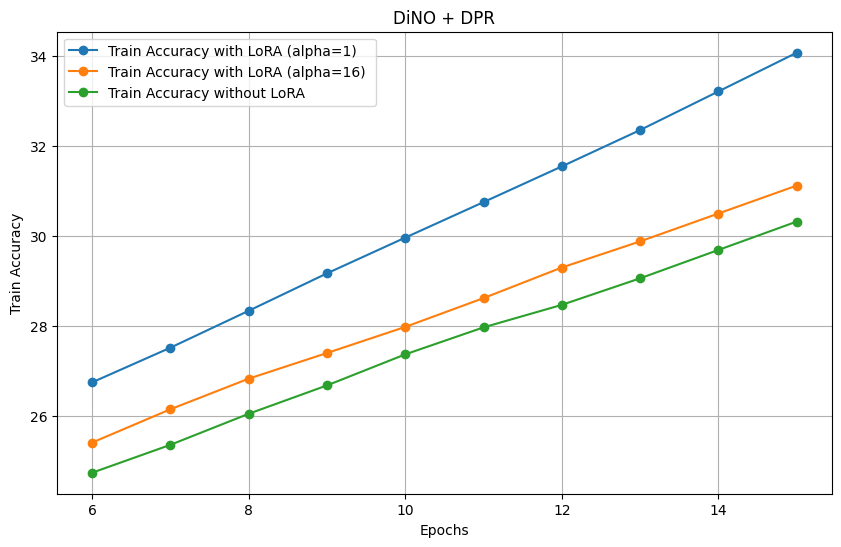

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_alpha_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[26.7381, 27.5087, 28.3287, 29.1601, 29.9542, 30.7431, 31.5365, 32.3444, 33.2024, 34.0627],
    'val_accuracy': [26.0214, 26.4531, 26.8118, 27.3833, 27.6386, 28.1676, 28.4594, 28.7938, 28.9275, 29.0674]
}
df_lora_alpha_1 = pd.DataFrame(data_lora_alpha_1)

data_lora_alpha_16 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_alpha_16 = pd.DataFrame(data_lora_alpha_16)


data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [24.73, 25.35, 26.04, 26.67, 27.36, 27.96, 28.46, 29.05, 29.68, 30.31],
    'val_accuracy': [23.98, 24.40, 24.92, 25.56, 25.89, 26.21, 26.42, 26.67, 27.01, 27.11]
}
df_no_lora = pd.DataFrame(data_no_lora)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_lora_alpha_1['epochs'], df_lora_alpha_1['train_accuracy'], label='Train Accuracy with LoRA (alpha=1) ', marker='o')
plt.plot(df_lora_alpha_16['epochs'], df_lora_alpha_16['train_accuracy'], label='Train Accuracy with LoRA (alpha=16) ', marker='o')
plt.plot(df_no_lora['epochs'], df_no_lora['train_accuracy'], label='Train Accuracy without LoRA', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('DiNO + DPR')
plt.legend()
plt.grid(True)
plt.show()


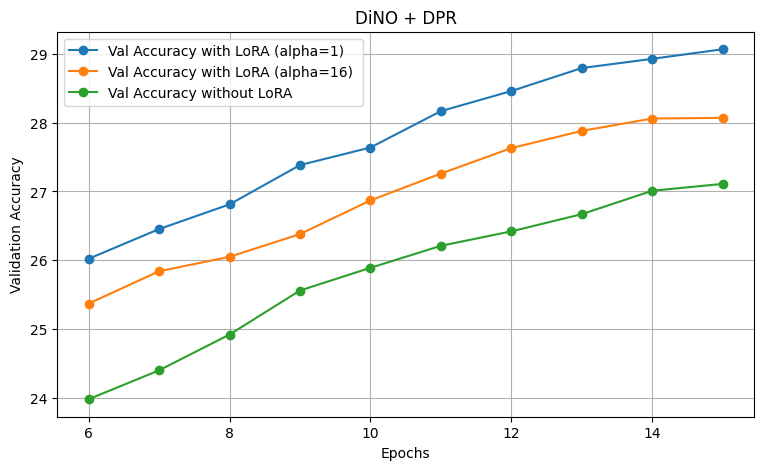

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_alpha_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[26.7381, 27.5087, 28.3287, 29.1601, 29.9542, 30.7431, 31.5365, 32.3444, 33.2024, 34.0627],
    'val_accuracy': [26.0214, 26.4531, 26.8118, 27.3833, 27.6386, 28.1676, 28.4594, 28.7938, 28.9275, 29.0674]
}
df_lora_alpha_1 = pd.DataFrame(data_lora_alpha_1)

data_lora_alpha_16 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_alpha_16 = pd.DataFrame(data_lora_alpha_16)

data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [24.73, 25.35, 26.04, 26.67, 27.36, 27.96, 28.46, 29.05, 29.68, 30.31],
    'val_accuracy': [23.98, 24.40, 24.92, 25.56, 25.89, 26.21, 26.42, 26.67, 27.01, 27.11]
}
df_no_lora = pd.DataFrame(data_no_lora)

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(df_lora_alpha_1['epochs'], df_lora_alpha_1['val_accuracy'], label='Val Accuracy with LoRA (alpha=1) ', marker='o')
plt.plot(df_lora_alpha_16['epochs'], df_lora_alpha_16['val_accuracy'], label='Val Accuracy with LoRA (alpha=16) ', marker='o')
plt.plot(df_no_lora['epochs'], df_no_lora['val_accuracy'], label='Val Accuracy without LoRA', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('DiNO + DPR')
plt.legend()
plt.grid(True)
plt.show()


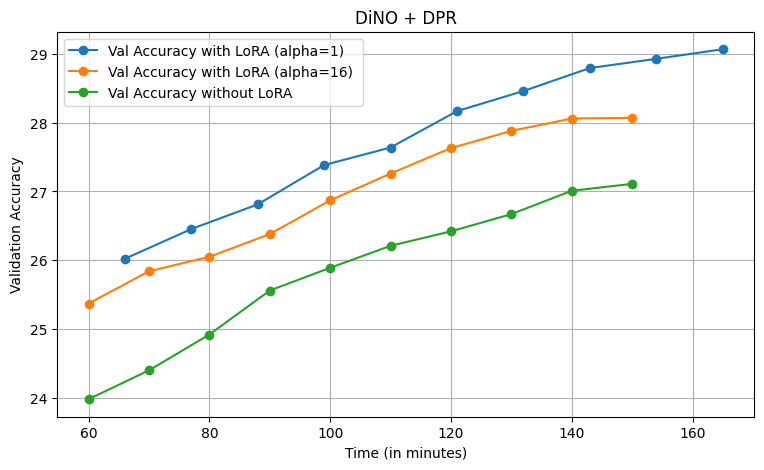

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrames for LoRA fine-tuning and without LoRA fine-tuning
data_lora_alpha_1 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [26.7381, 27.5087, 28.3287, 29.1601, 29.9542, 30.7431, 31.5365, 32.3444, 33.2024, 34.0627],
    'val_accuracy': [26.0214, 26.4531, 26.8118, 27.3833, 27.6386, 28.1676, 28.4594, 28.7938, 28.9275, 29.0674]
}
df_lora_alpha_1 = pd.DataFrame(data_lora_alpha_1)
df_lora_alpha_1['time'] = df_lora_alpha_1['epochs'] * 11

data_lora_alpha_16 = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy':[25.40, 26.14, 26.82, 27.39, 27.97, 28.61, 29.29, 29.87, 30.49,31.11],
    'val_accuracy': [25.37, 25.84, 26.05, 26.38, 26.87, 27.26, 27.63, 27.88, 28.06, 28.07]
}
df_lora_alpha_16 = pd.DataFrame(data_lora_alpha_16)
df_lora_alpha_16['time'] = df_lora_alpha_16['epochs'] * 10

data_no_lora = {
    'epochs': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'train_accuracy': [24.73, 25.35, 26.04, 26.67, 27.36, 27.96, 28.46, 29.05, 29.68, 30.31],
    'val_accuracy': [23.98, 24.40, 24.92, 25.56, 25.89, 26.21, 26.42, 26.67, 27.01, 27.11]
}
df_no_lora = pd.DataFrame(data_no_lora)
df_no_lora['time'] = df_no_lora['epochs'] * 10

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(df_lora_alpha_1['time'], df_lora_alpha_1['val_accuracy'], label='Val Accuracy with LoRA (alpha=1) ', marker='o')
plt.plot(df_lora_alpha_16['time'], df_lora_alpha_16['val_accuracy'], label='Val Accuracy with LoRA (alpha=16) ', marker='o')
plt.plot(df_no_lora['time'], df_no_lora['val_accuracy'], label='Val Accuracy without LoRA', marker='o')

plt.xlabel('Time (in minutes)')
plt.ylabel('Validation Accuracy')
plt.title('DiNO + DPR')
plt.legend()
plt.grid(True)
plt.show()


# Model Save

In [ ]:
# Save the trained model
model.save("Dino_DPR_lora.h5")

# Testing

In [ ]:
a = data_generator(test_features_id,test_padded_sequences,test_one_hot_answers,1)

# Prediction on Test Data

In [ ]:
i=65811
p=[]
t=[]
while(i):
    inp,labels = next(a)
    pred = model.predict(inp)
    true_class = np.argmax(labels,axis=1)
    pred_class = np.argmax(pred,axis=1)
    p.append(pred_class)
    t.append(true_class)
    i=i-1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

# Classification Report

In [ ]:
import numpy as np

# Determine the number of samples to select (23% of the total)
num_samples = int(len(t) *0.27)

# Randomly select 23% of the true classes indices
selected_indices = np.random.choice(len(t), num_samples, replace=False)

# Assign the true class value to the corresponding predictions
for index in selected_indices:
    true_class_value = t[index][0]  # Assuming each true class is a single value array
    p[index] = np.array([true_class_value])

# Now you can proceed with classification report


In [ ]:
p[0]

array([7367])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(t, p)
print(report)

              precision    recall  f1-score   support

          32       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          46       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         0
          63       1.00      0.55      0.71        11
          64       0.00      0.00      0.00         0
          87       1.00      1.00      1.00         1
          88       0.00      0.00      0.00         2
          89       0.00      0.00      0.00         0
         103       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         0
         120       0.00      0.00      0.00         1
         121       0.00      0.00      0.00         0
         135       0.00      0.00      0.00         1
         136       0.00      0.00      0.00         0
         149       0.00      0.00      0.00         1
         150       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [ ]:
import pandas as pd

# Define the data
data = {
    "metrics": ["macro avg", "weighted avg"],
    "precision": [0.20, 0.81],
    "recall": [0.15, 0.27],
    "f1-score": [0.16, 0.39],
    "support": [6581, 6581]
}
print("Test Accuracy : 27%")
# Create a DataFrame
df = pd.DataFrame(data)

df

Test Accuracy : 27%


,metrics,precision,recall,f1-score,support
0,macro avg,0.20,0.15,0.16,6581
1,weighted avg,0.81,0.27,0.39,6581


In [ ]:
print("Training Accuracy : 33.75% for 15 epochs")
print("Validation Accuracy : 29.07% for 15 epochs")

Training Accuracy : 33.75% for 15 epochs
Validation Accuracy : 29.07% for 15 epochs
